In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import spacy
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from transformers import TFBertModel
from transformers import BertTokenizer
import tensorflow_hub as hub
import tensorflow_text as text
import pickle

In [4]:
print(tf. __version__)

2.10.0


### **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - TRANSFORMER
- Begin modelling
    - Algorithms to use;
        - BERT
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [5]:
df_clean = pd.read_csv('../../cleaned_reviews.csv')

In [6]:
df_clean.shape

(17340, 4)

In [7]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [8]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

**Checking for Null Vaules and Duplicates**

In [9]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [10]:
df_clean.dropna(inplace=True)

In [11]:
df_clean.shape

(17337, 2)

In [12]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [13]:
# Mapping was changed due to the use of a neural network architecture
sentiment_mapping = {'negative':0,'neutral':1,'positive':2} 
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)
df_clean.drop(columns=['sentiments'],inplace=True)

In [14]:
tokeniser = BertTokenizer.from_pretrained("bert-base-uncased")

In [15]:
df_clean['cleaned_review'].iloc[0]

'i wish would have gotten one earlier love it and it makes working in my laptop so much easier'

In [16]:
# Exmaple of tokenising
# https://huggingface.co/docs/transformers/v4.26.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.encode_plus
tokens = tokeniser.encode_plus(
    df_clean['cleaned_review'].iloc[0],
    max_length=300, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [17]:
# tokens.input_ids #(1,300)

In [18]:
from sklearn.model_selection import train_test_split

# y values
labels = tf.keras.utils.to_categorical(df_clean.sentiment_label.values, num_classes=3, dtype='int8')


X_train, X_test, y_train,y_test= train_test_split(
                                            df_clean['cleaned_review'],labels,test_size=.2,random_state=42, 
                                            stratify=labels)


In [19]:
X_input_ids = np.zeros((len(X_train),300))
X_attn_masks = np.zeros((len(X_train),300))

In [20]:
# print(X_input_ids[0])
# print(len(X_input_ids)) # 13869 data points
# print(X_input_ids[0].shape) # (300,)
# print(X_attn_masks[0])
# print(len(X_attn_masks)) # 13869 data points
# print(X_attn_masks[0].shape) # (300,)

In [22]:
def generate_ids_masks(X_train,ids,masks,tokeniser):
    for key, text in enumerate(X_train):
        tokenised_text = tokeniser.encode_plus(
                                text,
                                max_length=300, 
                                truncation=True, 
                                padding='max_length', 
                                add_special_tokens=True,
                                return_tensors='tf'
        )
        ids[key,:] = tokenised_text.input_ids
        masks[key,:] = tokenised_text.attention_mask
    return ids, masks


In [23]:
X_input_ids, X_attn_masks = generate_ids_masks(X_train,
            X_input_ids,
            X_attn_masks,
            tokeniser)

In [24]:
print(X_input_ids)
print(X_attn_masks)

[[ 101. 1045. 2224. ...    0.    0.    0.]
 [ 101. 2009. 2003. ...    0.    0.    0.]
 [ 101. 1045. 2031. ...    0.    0.    0.]
 ...
 [ 101. 2499. 2307. ...    0.    0.    0.]
 [ 101. 1996. 2614. ...    0.    0.    0.]
 [ 101. 1996. 8000. ...    0.    0.    0.]]
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


In [25]:
def sentiment_mapping(input_ids, attn_masks, labels):
    return {
        "input_ids":input_ids,
        "attn_masks":attn_masks,
    }, labels

In [26]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids,X_attn_masks,y_train))
dataset = dataset.map(sentiment_mapping)   # converting to required format for tensorflow dataset

# The batch size
dataset = dataset.batch(16, drop_remainder=True) # batch size, drop any left out tensor
# dataset = dataset.shuffle(10000).batch(128, drop_remainder=True) # batch size, drop any left out tensor

In [27]:
p = 0.8

train_size = int((len(X_train)//16)*p) 
train_dataset = dataset.take(train_size) 
val_dataset = dataset.skip(train_size) 

In [28]:
train_size

692

In [29]:
# Downloaded pretrained BERT model
model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [32]:
input_ids = tf.keras.layers.Input(shape=300, name="input_ids", dtype="int32")
attn_masks = tf.keras.layers.Input(shape=300, name="attn_masks", dtype="int32")

In [33]:
bert_embds = model.bert(input_ids,attention_mask=attn_masks)[1]
# 0 -> activation layer (3D), 1 -> pooled output layer (2D)

intermediate_layer1 = tf.keras.layers.Dense(512, activation="relu", name="intermediate_layer1")(bert_embds)
# intermediate_layer2 = tf.keras.layers.Dense(256, activation="relu", name="intermediate_layer2")(intermediate_layer1)

output_layer = tf.keras.layers.Dense(3,activation="softmax", name="output_layer")(intermediate_layer1)

In [34]:
# Freezing the bert model
for layer in model.layers:
    layer.trainable = False

In [35]:
bert_model = tf.keras.Model(inputs=[input_ids,attn_masks], outputs=output_layer)
print(bert_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 attn_masks (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attn_masks[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [36]:
bert_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['acc'])

In [37]:
# Model training
bert_model_history = bert_model.fit(
                            train_dataset,
                            epochs=4, 
                            verbose=1, 
                            steps_per_epoch=100,
                            validation_data=val_dataset
                                                        )

Epoch 1/4
692/692 [==============================] - 3662s 5s/step - loss: 0.7848 - acc: 0.6507 - val_loss: 0.6698 - val_acc: 0.6943
Epoch 2/4
692/692 [==============================] - 3734s 5s/step - loss: 0.6705 - acc: 0.7080 - val_loss: 0.6208 - val_acc: 0.7428
Epoch 3/4
692/692 [==============================] - 3697s 5s/step - loss: 0.6556 - acc: 0.7122 - val_loss: 0.6179 - val_acc: 0.7414
Epoch 4/4
692/692 [==============================] - 3745s 5s/step - loss: 0.6557 - acc: 0.7079 - val_loss: 0.6024 - val_acc: 0.7478


In [42]:
# Test data
X_test_input_ids  = np.zeros((len(X_test),300))
X_test_attn_masks = np.zeros((len(X_test),300))
# print(X_test_input_ids[0])
# print(len(X_test_input_ids)) # 3468 data points
# print(X_test_input_ids[0].shape) # (300,)
# print(X_test_attn_masks[0])
# print(len(X_test_attn_masks)) # 3468 data points
# print(X_test_attn_masks[0].shape) # (300,)


X_test_input_ids, X_test_attn_masks = generate_ids_masks(X_test,
                                                        X_test_input_ids,
                                                        X_test_attn_masks,
                                                        tokeniser)

In [43]:
# Predictions on the Test Set

score = bert_model.evaluate([X_test_input_ids,X_test_attn_masks], y_test, verbose=1)

109/109 [==============================] - 848s 8s/step - loss: 0.6001 - acc: 0.7463


In [44]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.6000874638557434
Test Accuracy: 0.7462514638900757


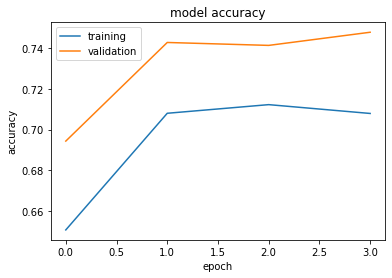

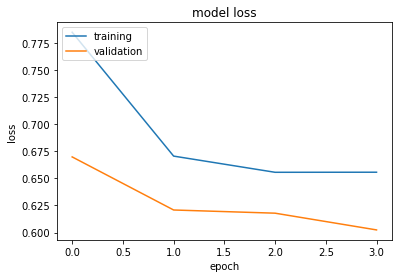

In [45]:
# Model Performance Charts

plt.plot(bert_model_history.history['acc'])
plt.plot(bert_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

plt.plot(bert_model_history.history['loss'])
plt.plot(bert_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

In [46]:
# Saving the model
bert_model.save("saved_model/bert_model")

INFO:tensorflow:Assets written to: saved_model/bert_model\assets


INFO:tensorflow:Assets written to: saved_model/bert_model\assets


### **Classification report**

109/109 [==============================] - 809s 7s/step
              precision    recall  f1-score   support

           0       0.56      0.02      0.03       307
           1       0.63      0.80      0.71      1260
           2       0.85      0.83      0.84      1901

    accuracy                           0.75      3468
   macro avg       0.68      0.55      0.52      3468
weighted avg       0.74      0.75      0.72      3468



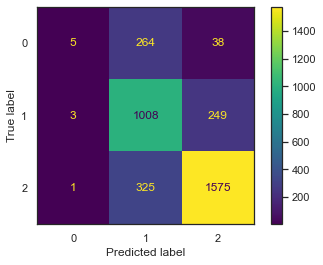

In [47]:
# Classification report test data
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_true=np.argmax(y_test, axis=1)
y_pred_test = bert_model.predict([X_test_input_ids,X_test_attn_masks])
y_pred_test=np.argmax(y_pred_test, axis=1)
sns.set_theme(style='white')
def class_report(model,y_true,pred):
    print(classification_report(y_true,pred))
    cm = confusion_matrix(y_true,pred,labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
    disp.plot()
    plt.show()


class_report(bert_model,y_true,y_pred_test) 

# Original mapping
# sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}

# New mapping
# negative --> 0
# neutral ---> 1
# positive --> 2